# Проект 4. Компьютер говорит «Нет» 

чуть позже появится вступительное слово

# import

In [209]:
from pandas import Series
import pandas as pd
import numpy as np
import datetime
import os
#import dtale  # Удобная библиотека-модуль для просмотра и анализа ДФ
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

pd.set_option('display.max_columns', 50)  # Настройка для отображения 50-ти колонок

In [210]:
# Можно зафиксировать версию пакетов, чтобы эксперименты были воспроизводимы
#!pip freeze > requirements.txt

# Дополнительные функции для удобства дальнейшей работы

In [211]:
def IQR_for_column(column):
    """Функция возвращает квартили, выводит границы для выбросов, согласно IQR и считает сколько выбросов (в том числе в %)"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + len(data[data[column] < min_out])
    print(
    '25-й перцентиль: {} |'.format(perc25),
    '75-й перцентиль: {} |'.format(perc75),
    "IQR: {} | ".format(IQR),
    "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(anomaly, anomaly/len(data)))
    
    
def pain_histplot(column, bins='auto', discrete=True, kde=True):
    "Функция для постороения графика распределения значений одного столбца"
    sns.set(font_scale=1.4)
    plt.figure(figsize=(18, 6))
    sns.histplot(data[column], discrete=discrete, color='blue', bins=bins, kde=kde)
    

def boxplot_for_cat(column, describe, figsize=(16, 3)):
    """Функция для создания boxplot для категориального признака"""
    sns.set(font_scale=1.4)
    plt.subplots(figsize=figsize)
    plt.xticks(ticks=range(0, 101, 5))
    plt.title('Распределение оценок в зависимости от ' + describe)
    sns.boxplot(y=column, x=data.default, color='royalblue', orient='h')
    plt.xlabel('Количество баллов')
    
def log_column(column):
    "Функция логарифмируем значения в столбце, рисует график нового распределения и выводит данные IQR"
    data[column] = np.log(data[column] + 1)
    IQR_for_column(column)
    pain_distplot(column)

In [212]:
def show_metrics(y_test, y_pred):
    """Функция выводит различные метрики для оценки качества модели """
    print('Верность - accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
    print('Точность - precision_score: {}'.format(np.round(precision_score(y_test, y_pred), 4)))
    print('Полнота - recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
    print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))

    
def pain_roc_curve(y_test, y_proba, y_pred):
    """Функция отрисовывает roc curve и confusion матрицу"""
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.set(font_scale=1)
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.6g')

# Обзор данных

In [213]:
# Для Kaggle
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [214]:
# Загружаем все данные
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

Задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

**Описания признаков:**
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы 
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [215]:
train.info()
display(train.sample(3))
print("Размер датасета для обучения: {}".format(train.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
10825,25264,01FEB2014,SCH,F,35,N,N,1,0,-1.523870,1,50,1,1,30000,1,2,N,0
19945,27996,04FEB2014,SCH,M,30,N,N,0,0,-2.070302,0,50,3,3,50000,4,4,N,0
11619,41094,17FEB2014,GRD,M,46,Y,Y,0,0,-2.656705,2,50,1,2,80000,1,3,N,0


Размер датасета для обучения: (73799, 19)


In [216]:
test.info()
display(test.sample(3))
print("Размер датасета для сабмита: {}".format(test.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
34284,79864,27MAR2014,UGR,M,39,N,N,1,0,-2.255649,6,50,2,3,40000,1,3,N
31946,32049,07FEB2014,GRD,F,58,Y,Y,0,0,-2.125397,0,50,1,2,85000,1,4,N
24052,38933,15FEB2014,SCH,F,30,N,N,0,0,-2.674300,1,50,2,3,21000,4,1,N


Размер датасета для сабмита: (36349, 18)


In [217]:
sample.info()
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


Имеем два датасета: обучающий и тестовый. Для объектов первого известна целевая переменная (дефолт). На основании обущающего датасета (train) необходимо создать модель и предсказать вероятность дефолта для клиентов из тестового датасета (test). samplen - это пример того, как должен выглядеть итоговый ответ, который необходимо загрузить на Kaggle. В качестве оценки качества модели в соревновании используется ROC AUC. Но эта метрика может не показать переобучение модели, поэтому надо будет проверять ещё с помощью других метрик (f1-score и confusion_matrix)

In [218]:
# Объединяем тест и трейн в один датафрейм
train['train'] = 1   
test['train'] = 0    
test['default'] = -1  # Добавим в тестовый датасет целевую переменную, равную -1
data = train.append(test, sort=False).reset_index(drop=True)

In [219]:
data.info()
display(data.sample(3))
print("Размер общего датасета: {}".format(data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
65273,72108,20MAR2014,SCH,M,61,Y,Y,0,0,-2.266981,1,40,2,3,50000,4,2,N,0,1
104954,67546,16MAR2014,SCH,M,49,Y,N,0,0,-2.307479,7,60,1,2,17000,1,4,N,-1,0
78256,46819,23FEB2014,UGR,F,31,N,N,0,0,-2.375096,0,60,1,2,25000,1,4,N,-1,0


Размер общего датасета: (110148, 20)


In [220]:
# Проверяем, где есть пропуски и дубликаты
print("Дубликатов найдено:", data.duplicated(keep=False).sum())
print("Пропусков найдено:", data.isnull().sum().sum())
data.isnull().sum()

Дубликатов найдено: 0
Пропусков найдено: 478


client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
train                 0
dtype: int64

In [221]:
# Можно изучить датафрейм с помощью удобной библиотеки
#data_modul = dtale.show(data)
#data_modul

**Краткий итог:** в тренировочкой выборке 73799 объектов, в тестовой 36349. После объединения имеем 110148 объектов. Целевая переменная ("default") отсутствовала в тестовой выборке - при объединении заменили эти пропущенные значения на "-1". Получилось 20 признаков (один из который был создан искусственно ('train') для обозначения из какой выборки данный объект). В обобщенном датафрейме отсутствуют дубликаты, а 478 пропусков находятся в одной колонке education.

**Примерный план работ:**
1. Подробно рассмотреть признаки по типам. Избавиться от пустых значений. Числовые признаки логарифмировать, если это улучшит распределение и уменьшит количество выбросов. Категориальные разбить на отдельные колонки. Значения в бинарных представить как 0 и 1. Избавиться от ненужных и "вредных" признаков. Построить простую модель_1, посмотреть значения разных метрик. 
2. Без добавления новых признаков добиться улучшения модели
3. Увеличить начальный датафрейм, добавив новые признаки. Оценить значимость признаков, избавиться от ненужных. Построить модель_3, посмотреть значения новых метрик.
4. "Поиграться" с гиперпараметрами
5. Выбрать лучшую модель

# Рассмотрим каждый признак отдельно

## default - целевая переменная

<AxesSubplot:title={'center':'Распределение клиентов с дефолтом и без'}, xlabel='count', ylabel='default'>

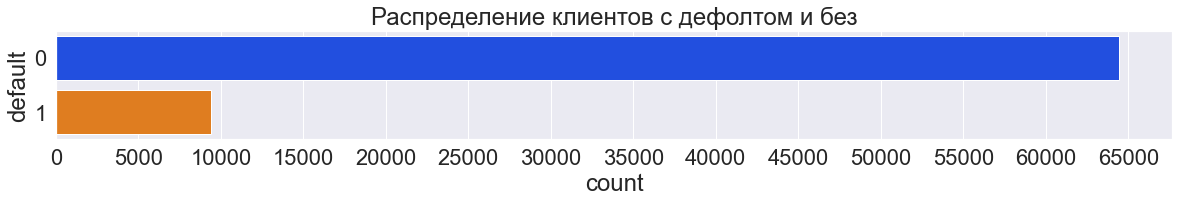

In [222]:
# Распределение классов
sns.set(font_scale=2)
plt.subplots(figsize=(20, 2))
plt.xticks(ticks=range(0, 65001, 5000))
plt.title('Распределение клиентов с дефолтом и без')
sns.countplot(y="default",
              data=train,
              order=train.default.value_counts().index,
              palette='bright')

Распределение целевой переменной ОЧЕНЬ неравномерно. В будущем это надо будет подправить перед построением модели

## client_id

In [223]:
print('Количество клиентов:', len(data))
data.client_id.value_counts()

Количество клиентов: 110148


2049     1
60104    1
39622    1
33477    1
35524    1
        ..
68875    1
66826    1
72969    1
70920    1
2047     1
Name: client_id, Length: 110148, dtype: int64

У каждого клиента свой идентификационный номер. С большой вероятностью этот признак можно не вносить в модель; он создавался автоматически в зависимости от очередности обращения клиента в банк. 

## Числовые признаки

### Зависимость целевой

In [224]:
# Все числовые признаки
num_col = ['age', 'decline_app_cnt', 'score_bki',
           'income', 'bki_request_cnt', 'region_rating']

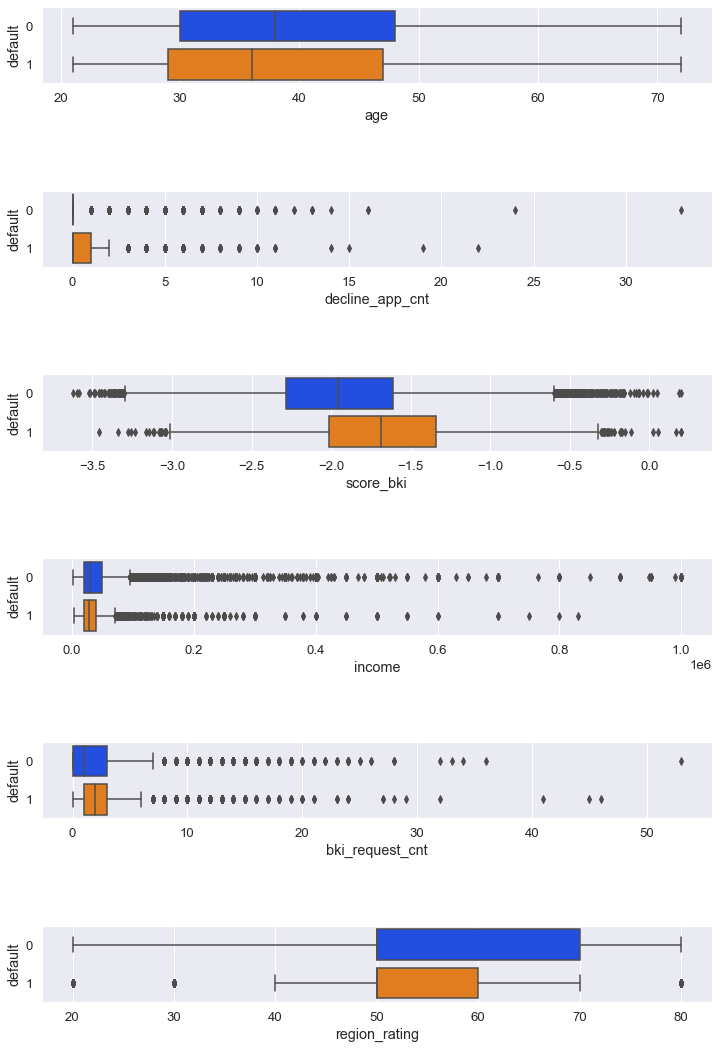

In [225]:
# Посмотрим зависимость целевой переменной от числовой
sns.set(font_scale=1.2)
plt.subplots(figsize=(12, 20))
k = 1  # Переменная, чтобы графики не "прилипали" друг к другу
for col in num_col:
    plt.subplot(12, 1, k)
    sns.boxplot(y=data[data['train'] == 1].default,
                x=data[data['train'] == 1][col], orient='h', palette='bright')
    k += 2

**Можно сделать несколько предварительных выводов:**
* Люди имеющие дефолт немного моложе
* Количество отказанных прошлых заявок больше у людей с дефолтом
* Скоринговый балл по данным из БКИ выше у людей с дефолтом
* Зарплата в среднем выше в людей без дефолта
* Количество запросов в БКИ в среднем выше у людей с дефолтом

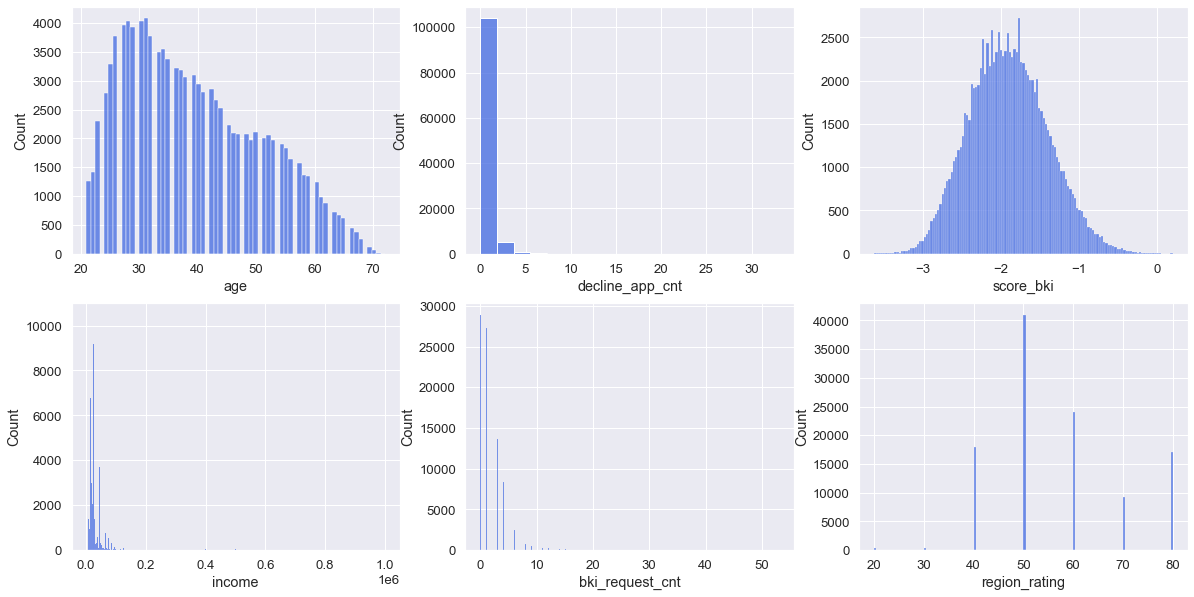

In [226]:
# Посмотрим распределение числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, col in enumerate(num_col):
    sns.histplot(data[col], kde=False, ax=axes.flat[i], color='royalblue')

Видно, что некоторые графики имеют тяжелый правый хвост. Изучим каждый числовой признак подробнее

### Age

25-й перцентиль: 30.0 | 75-й перцентиль: 48.0 | IQR: 18.0 |  Границы выбросов: [3.0, 75.0].
Выбросов, согласно IQR: 0 | 0.00%
None


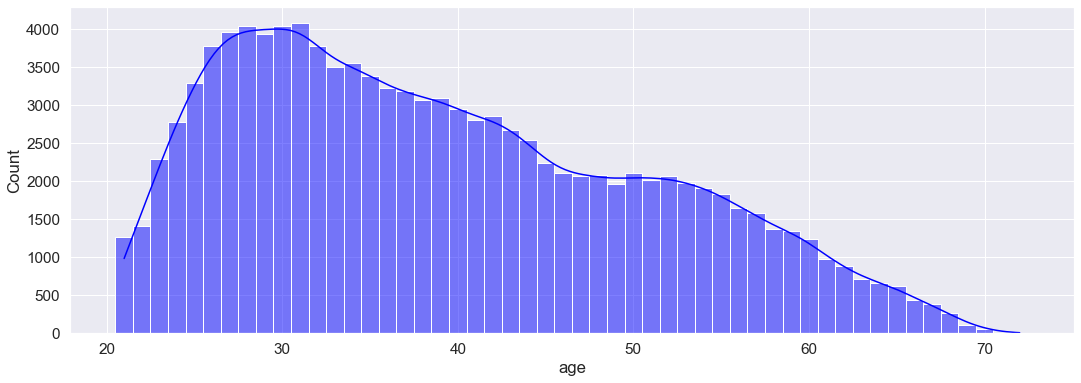

In [227]:
print(IQR_for_column('age'))
pain_histplot('age', bins=3)

In [228]:
# Если надо прологарифмировать
#log_column('age')

Логарифмирование не сильно поменяет картинку, оставим как есть, чтобы проще было интерпретировать. Выбросов нет

### decline_app_cnt

25-й перцентиль: 0.0 | 75-й перцентиль: 0.0 | IQR: 0.0 |  Границы выбросов: [0.0, 0.0].
Выбросов, согласно IQR: 18677 | 16.96%


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

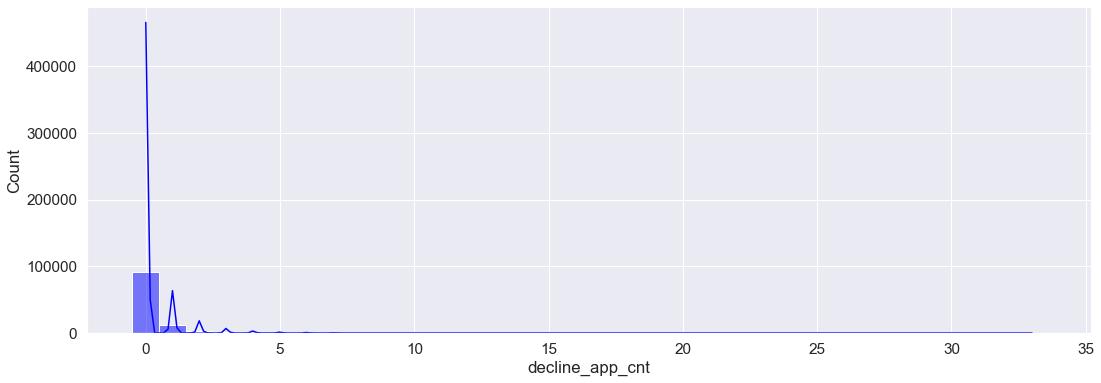

In [229]:
IQR_for_column('decline_app_cnt')
display(data.decline_app_cnt.value_counts())
pain_histplot('decline_app_cnt')

25-й перцентиль: 0.0 | 75-й перцентиль: 0.0 | IQR: 0.0 |  Границы выбросов: [0.0, 0.0].
Выбросов, согласно IQR: 18677 | 16.96%


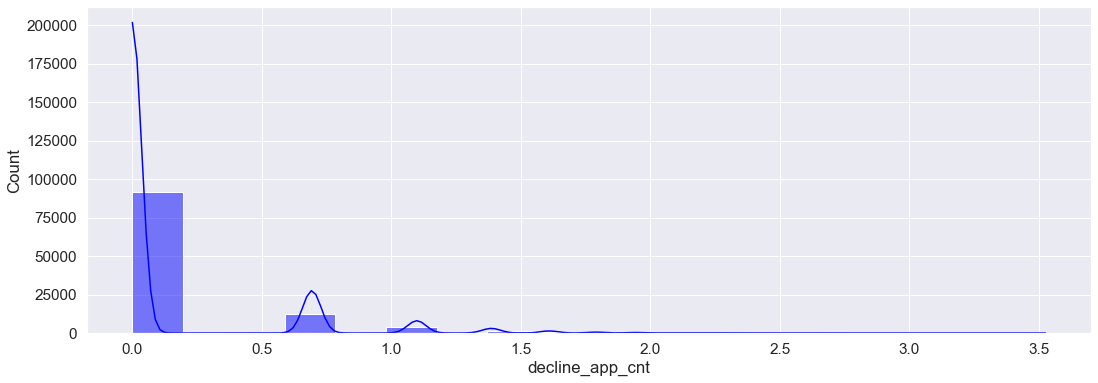

In [230]:
# Логарифмируем данный признак, чтобы немного сгладить "тяжёлый" правых хвост
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
IQR_for_column('decline_app_cnt')
pain_histplot('decline_app_cnt', discrete=False)

Рапределение слегка "разгладилось", хотя количество выбросов согласно IQR не уменьшилось

### score_bki

25-й перцентиль: -2.2604336700000003 | 75-й перцентиль: -1.5678881525 | IQR: 0.6925455175000004 |  Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Выбросов, согласно IQR: 518 | 0.47%


-1.775263    517
-2.104211    454
-2.225004    424
-2.169664    375
-2.024100    278
            ... 
-1.784307      1
-2.216105      1
-1.896095      1
-2.598073      1
-2.296371      1
Name: score_bki, Length: 102618, dtype: int64

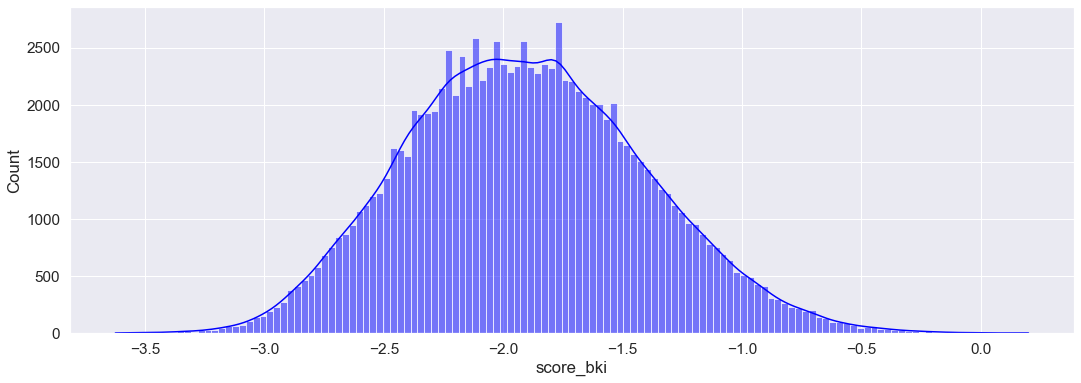

In [231]:
IQR_for_column('score_bki')
display(data.score_bki.value_counts())
pain_histplot('score_bki', discrete=False)

In [232]:
# Для лагорифмирования
#data['score_bki'] = np.log(data['score_bki'] + 1)
#IQR_for_column('score_bki')
#pain_histplot('score_bki', discrete=False)

Если логарифмировать, то количество выбросов согласно IQR уменьшится, но распределение станет "менее нормальным". Оставим как было

### income

25-й перцентиль: 20000.0 | 75-й перцентиль: 48000.0 | IQR: 28000.0 |  Границы выбросов: [-22000.0, 90000.0].
Выбросов, согласно IQR: 7000 | 6.36%


30000     10437
25000      9090
20000      8174
40000      7383
50000      6742
          ...  
96500         1
14620         1
16723         1
154000        1
32400         1
Name: income, Length: 1207, dtype: int64

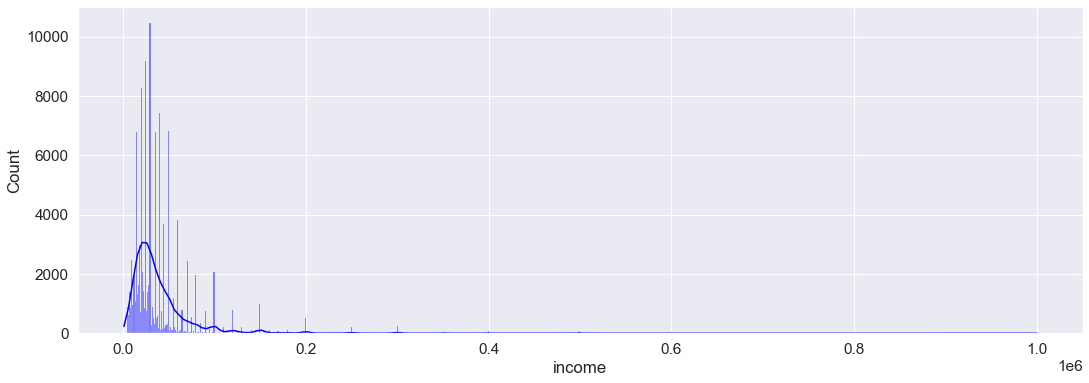

In [233]:
IQR_for_column('income')
display(data.income.value_counts())
pain_histplot('income', discrete=False)

25-й перцентиль: 9.90353755128617 | 75-й перцентиль: 10.778977123006351 | IQR: 0.8754395717201806 |  Границы выбросов: [8.590378193705899, 12.092136480586621].
Выбросов, согласно IQR: 2609 | 2.37%


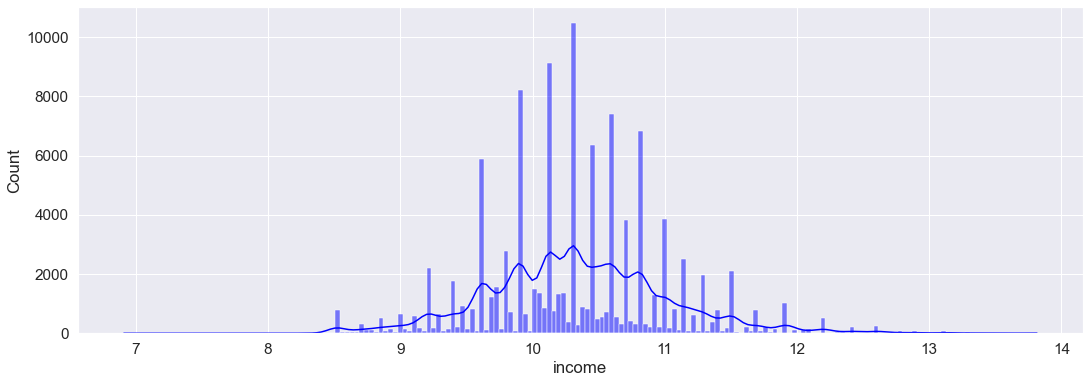

In [234]:
# Логарифмируем данный признак, чтобы немного сгладить "тяжёлый" правых хвост
data['income'] = np.log(data['income'] + 1)
IQR_for_column('income')
pain_histplot('income', discrete=False)

Данные значительно "выправились" и распределение стало напоминать нормальное. Почти в три раза уменьшилось количество выбросов согласно IQR

### bki_request_cnt

25-й перцентиль: 0.0 | 75-й перцентиль: 3.0 | IQR: 3.0 |  Границы выбросов: [-4.5, 7.5].
Выбросов, согласно IQR: 2636 | 2.39%
None


0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

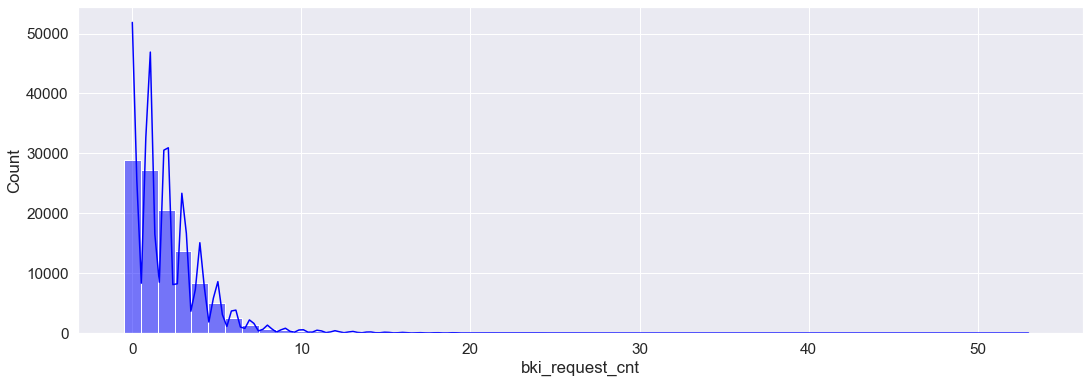

In [235]:
print(IQR_for_column('bki_request_cnt'))
display(data.bki_request_cnt.value_counts())
pain_histplot('bki_request_cnt')

25-й перцентиль: 0.0 | 75-й перцентиль: 1.3862943611198906 | IQR: 1.3862943611198906 |  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Выбросов, согласно IQR: 15 | 0.01%


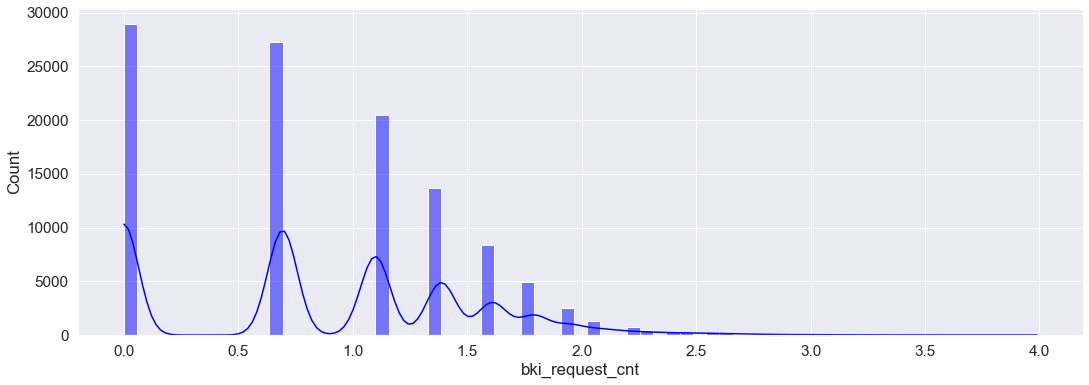

In [236]:
# Логарифмируем данный признак, чтобы немного сгладить "тяжёлый" правых хвост
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
IQR_for_column('bki_request_cnt')
pain_histplot('bki_request_cnt', discrete=False)

Данные "расправились". Почти все выбросы согласно IQR пропали.

### region_rating

25-й перцентиль: 50.0 | 75-й перцентиль: 60.0 | IQR: 10.0 |  Границы выбросов: [35.0, 75.0].
Выбросов, согласно IQR: 17917 | 16.27%


50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

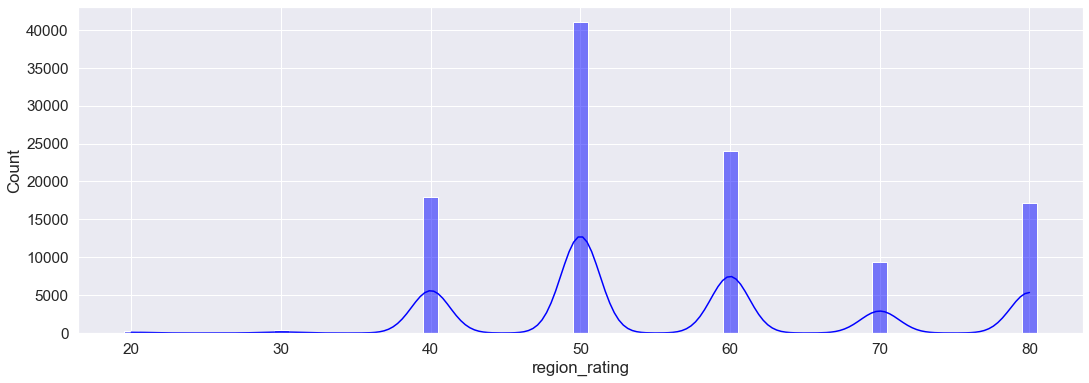

In [237]:
IQR_for_column('region_rating')
display(data.region_rating.value_counts())
pain_histplot('region_rating')

Можно представить эти данные как категориальны, но я решил оставить в виде числовых. Разделим все значения на 10 просто для удобства, чтобы "категории были ближе к друг другу

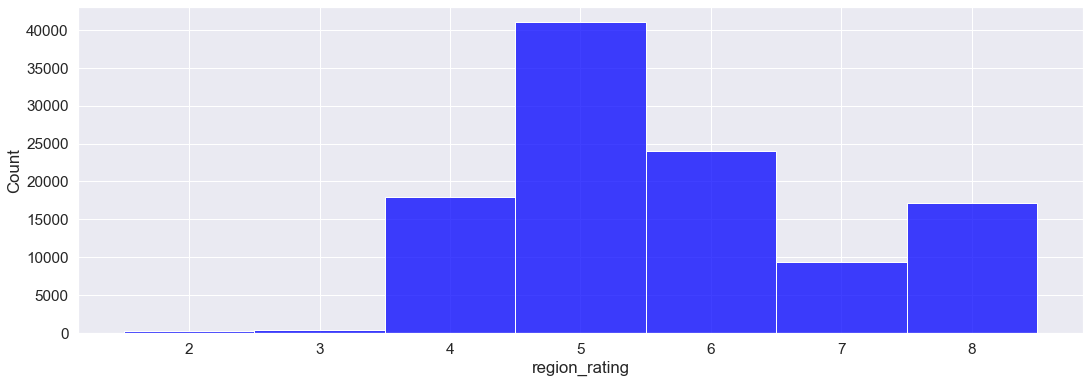

In [238]:
data['region_rating'] = data['region_rating'] / 10
pain_histplot('region_rating', kde=False)

### Мартица корреляции для числовых признаков

<AxesSubplot:>

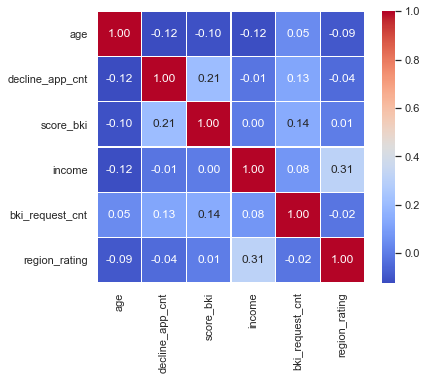

In [239]:
sns.set(font_scale=1)
plt.subplots(figsize=(6, 5))
sns.heatmap(data[num_col].corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

Сильной зависимости между числовыми признаками нет

## Категориальные признаки

### education

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64
SCH    0.526546
GRD    0.315648
UGR    0.133893
PGR    0.016932
NaN    0.004340
ACD    0.002642
Name: education, dtype: float64


<AxesSubplot:title={'center':'Образование'}, xlabel='count', ylabel='education'>

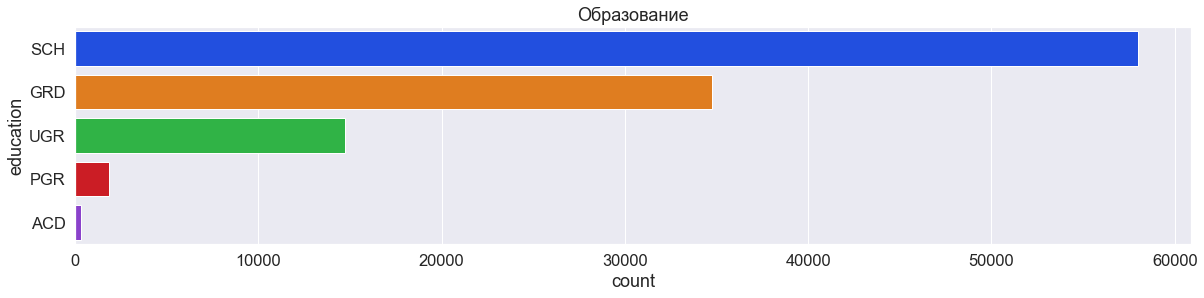

In [240]:
print(data.education.value_counts(dropna=False))
print(data.education.value_counts(dropna=False, normalize=True))

sns.set(font_scale=1.5)
plt.subplots(figsize=(20, 4))
plt.title('Образование')
sns.countplot(y="education", data=data, palette='bright')

Пропущено меньше 0.5% значений в образовании

<AxesSubplot:xlabel='Count', ylabel='education'>

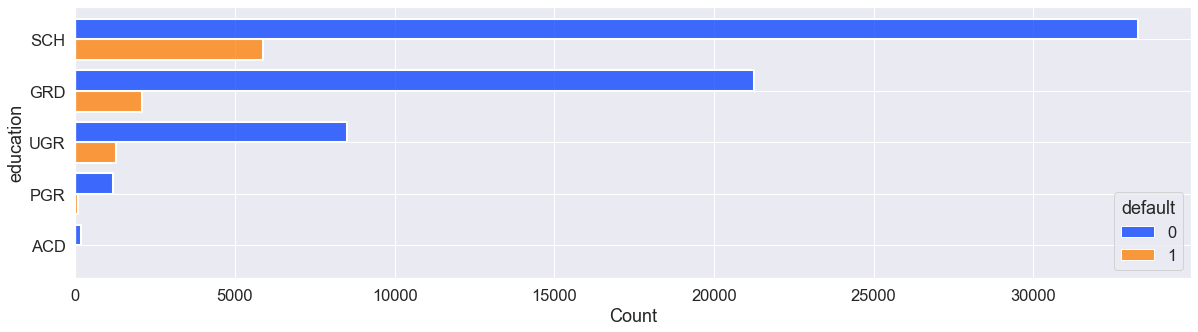

In [241]:
# Заменим пропуски на наиболее частое значение, которое к тому же является самым "низким" по образованию 
data.education.fillna('SCH', inplace=True)

sns.set(font_scale=1.5)
plt.subplots(figsize=(20, 5))
sns.histplot(data=data[data['train'] == 1], y="education", hue="default", multiple="dodge", shrink=.8, palette='bright')

### work_address, home_address, sna and first_time

3    0.609298
2    0.279270
1    0.111432
Name: work_address, dtype: float64
2    0.541008
1    0.442023
3    0.016968
Name: home_address, dtype: float64
1    0.641691
4    0.158705
2    0.143734
3    0.055870
Name: sna, dtype: float64
3    0.422958
4    0.254358
1    0.166104
2    0.156580
Name: first_time, dtype: float64


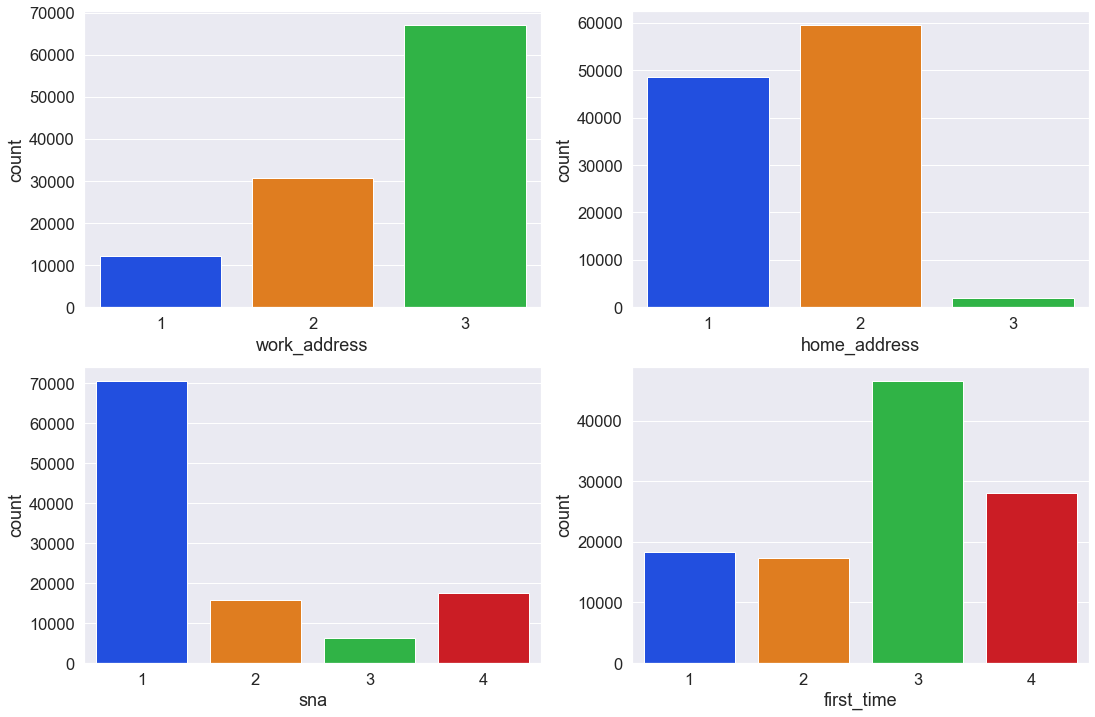

In [242]:
cat_col = ['work_address','home_address','sna','first_time']  # Оставшиеся категориальные признаки

for col in cat_col:
    print(data[col].value_counts(normalize=True))
    
plt.subplots(figsize=(18, 12))
for i,col in enumerate(cat_col):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=col, data=data, palette='bright')

Чуть позже сделаем dummy-признаких этих категориальных колонок. Значения можно не изменять, так как представлены числами

## Бинарные признаки

Закодируем бинарные признаки и сделаем словарь с ключами. Отдельно закодируем признак с образованием, а другие категориальные оставим без изменения, 
так как значения представлены числами 

In [243]:
bin_col = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] 

keys_for_bin = {}
label_encoder = LabelEncoder()
for col in bin_col:
    data[col] = label_encoder.fit_transform(data[col])
    keys_for_bin[col] = dict(enumerate(label_encoder.classes_))
    
data['education'] = label_encoder.fit_transform(data['education'])  
keys_for_bin['education'] = dict(enumerate(label_encoder.classes_))
keys_for_bin

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'},
 'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}}

# Подробно изучаем значимость признаков

<AxesSubplot:>

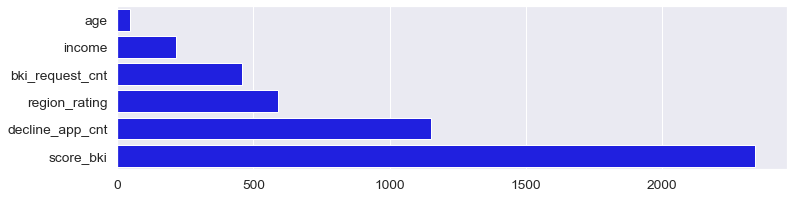

In [244]:
# Значимость для числовых признаков
temp_df = data[data['train'] == 1]
imp_num = Series(f_classif(temp_df[num_col], temp_df['default'])[0], index=num_col)
imp_num.sort_values(inplace=True)

sns.set(font_scale=1.25)
plt.figure(figsize=(12, 3))
sns.barplot(y=imp_num.index, x=imp_num.values , color='blue')

Возраст почти не влияет на значение целевой переменной. Интересно, что уровень зарплаты тоже имеет довольно низкое значени

<AxesSubplot:>

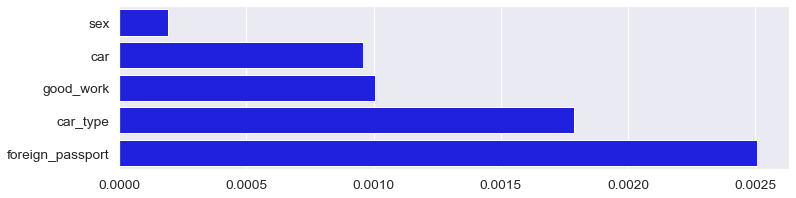

In [245]:
# Значимость для бинарных признаков
temp_df = data[data['train'] == 1]
imp_bin = Series(mutual_info_classif(
    temp_df[bin_col], temp_df['default'], discrete_features=True), index=bin_col)
imp_bin.sort_values(inplace=True)

sns.set(font_scale=1.25)
plt.figure(figsize=(12, 3))
sns.barplot(y=imp_bin.index, x=imp_bin.values , color='blue')

Наибольшее значение имеет наличие загранпаспорта. Пол влиет меньше всего

<AxesSubplot:>

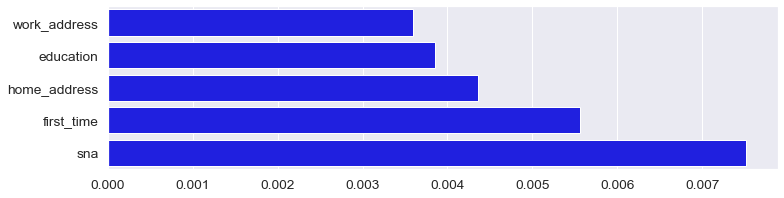

In [246]:
# Добавим в список категориальных признаков образование, которое мы раньше не внесли в этот список
cat_col.append('education') 

# Значимость для категориальных признаков
temp_df = data[data['train'] == 1]
imp_cat = Series(mutual_info_classif(
    temp_df[cat_col], temp_df['default'], discrete_features=True), index=cat_col)
imp_cat.sort_values(inplace=True)

sns.set(font_scale=1.25)
plt.figure(figsize=(12, 3))
sns.barplot(y=imp_cat.index, x=imp_cat.values , color='blue')

In [247]:
# Сделаем дамми-признаки категориальных столбцов
data = pd.get_dummies(data, columns = cat_col)

<AxesSubplot:>

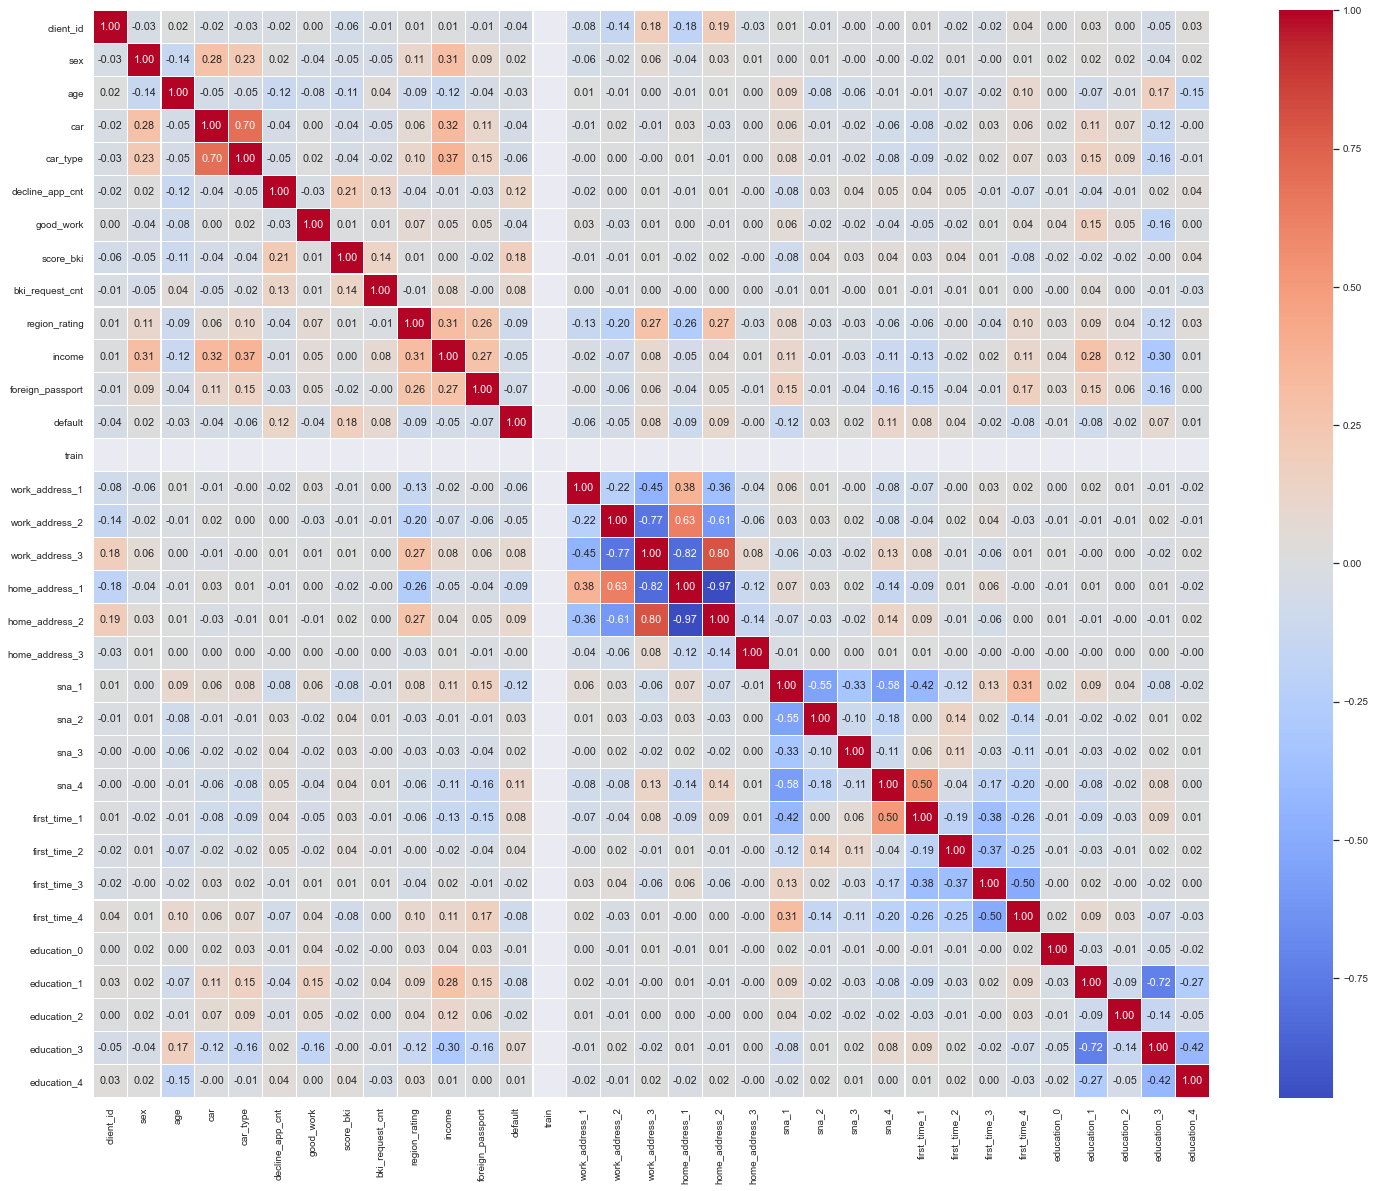

In [248]:
# Посмотрим на матрицу корреляций (только по трейну!, т.к. в тесте default поставили равным -1)
sns.set(font_scale=0.9)
plt.subplots(figsize=(25, 20))
sns.heatmap(data[data['train'] == 1].corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

In [249]:
# Удалим по признаку из категориальных dummy признаков,чтобы избавиться от мультиколлинеарности.
data.drop(['home_address_1', 'work_address_3', 'sna_3', 'education_4', 'first_time_3'], axis=1, inplace=True)

# Сделаем копию датафрейма
df = data.copy()

# Удалим номер айди и дату (c которой мы пока решили не работать)
df.drop(['client_id', 'app_date'], axis=1, inplace=True)

Ниже код для проверки корреляции после удаления каких-либо категориальных признаков. Подбирал так, чтобы с целевой переменной была лучше зависимость

In [250]:
'''df_cat = df.drop(['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating', 
                  'sex', 'car', 'car_type', 'good_work', 'foreign_passport'], axis=1, inplace=True)
sns.set(font_scale=0.9)
plt.subplots(figsize=(15, 8))
sns.heatmap(df_cat[df_cat['train'] == 1].corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")'''

'df_cat = df.drop([\'age\',\'decline_app_cnt\',\'score_bki\',\'income\',\'bki_request_cnt\',\'region_rating\', \n                  \'sex\', \'car\', \'car_type\', \'good_work\', \'foreign_passport\'], axis=1, inplace=True)\nsns.set(font_scale=0.9)\nplt.subplots(figsize=(15, 8))\nsns.heatmap(df_cat[df_cat[\'train\'] == 1].corr(), annot=True, fmt=\'.2f\', linewidths=0.1, cmap="coolwarm")'

# Самая простая модель, без новых признаков

In [251]:
# Разбиваем выборку обратно на трейн и тест
df_train = df.query('train == 1').drop(['train'], axis=1)
df_test = df.query('train == 0').drop(['train'], axis=1)

# Делим тренировочные данные на обучающуюся и проверочную
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [252]:
# Обычная логистическая регрессия
model_1 = LogisticRegression(max_iter=2000)  # Итераций сделал побольше, чтобы не выскакивала ошибка
model_1.fit(x_train, y_train)
y_pred_1 = model_1.predict(x_test)
y_proba_1 = model_1.predict_proba(x_test)[:, 1]

Верность - accuracy_score: 0.8753
Точность - precision_score: 0.0213
Полнота - recall_score: 0.4239
f1_score: 0.0406


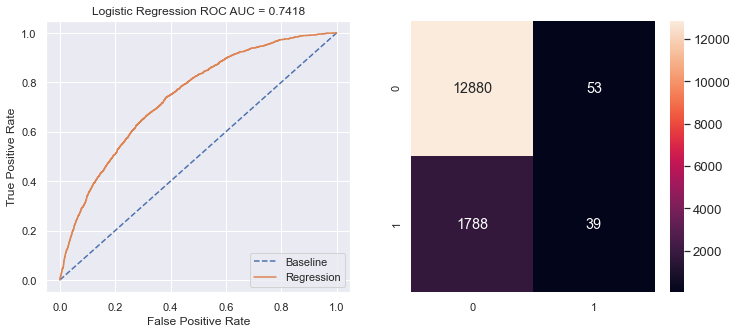

In [253]:
pain_roc_curve(y_test, y_proba_1, y_pred_1)
show_metrics(y_pred_1, y_test)

Неплохое значение ROC и красивая картинка. Но! Очень низкое значение f1_score и confusion_matrix говорят о переобучении модели. Будем исправлять. Разбираемся, что упустили

# Подправляем модель, всё ещё без новых признаков

In [254]:
from imblearn.under_sampling import RandomUnderSampler

# Делим тренировочные данные на обучающуюся и проверочную
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values

rus = RandomUnderSampler(random_state=42)
X_us, Y_us = rus.fit_resample(X, Y)

# Стандартизируем значения признаков
X = StandardScaler().fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_us, Y_us, test_size=0.20, random_state=42)

In [255]:
# Вспоминаем, что целевая переменная распределена неравномерно. Сделаем oversampling, т.е. сделаем копии объектов, где default=1
#default_0 = df_train[df_train['default'] == 0]
#default_1 = df_train[df_train['default'] == 1]
#default_new = int(len(default_0)/len(default_1))
#for i in range(default_new):
#    df_train = df_train.append(default_1).reset_index(drop=True) 

# Делим тренировочные данные на обучающуюся и проверочную
#X = df_train.drop(['default'], axis=1).values
#Y = df_train['default'].values

# Стандартизируем значения признаков
#X = StandardScaler().fit_transform(X)

#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [256]:
# Делаем обычную логистическую регрессию
model_2 = LogisticRegression(max_iter=2000)
model_2.fit(x_train, y_train)
y_pred_2 = model_2.predict(x_test)
y_proba_2 = model_2.predict_proba(x_test)[:, 1]

Верность - accuracy_score: 0.6772
Точность - precision_score: 0.6864
Полнота - recall_score: 0.6712
f1_score: 0.6787


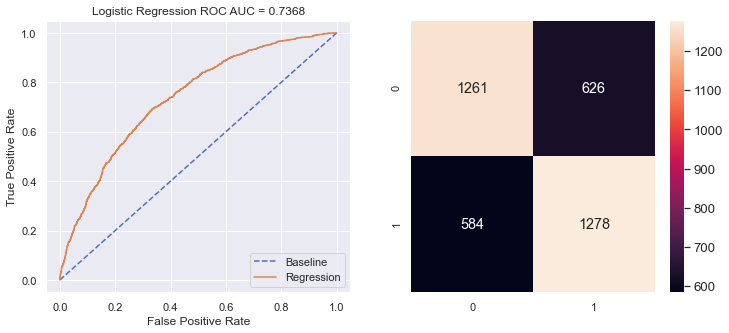

In [257]:
pain_roc_curve(y_test, y_proba_2, y_pred_2)
show_metrics(y_pred_2, y_test)

Значение ROC слегка уменьшилось, зато значения остальных метрик улучшилось (главное, что f1 стало значительно выше)

# Генерация новых признаков

In [258]:
data.head(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,default,train,work_address_1,work_address_2,home_address_2,home_address_3,sna_1,sna_2,sna_4,first_time_1,first_time_2,first_time_4,education_0,education_1,education_2,education_3
0,25905,01FEB2014,1,62,1,1,0.000000,0,-2.008753,0.693147,5.0,9.798183,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
1,63161,12MAR2014,0,59,0,0,0.000000,0,-1.532276,1.386294,5.0,9.852247,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1
2,25887,01FEB2014,1,25,1,0,1.098612,0,-1.408142,0.693147,8.0,10.308986,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,16222,23JAN2014,0,53,0,0,0.000000,0,-2.057471,1.098612,5.0,9.210440,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,101655,18APR2014,1,48,0,0,0.000000,1,-1.244723,0.693147,6.0,10.308986,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0


In [259]:
# Добавим средние значения  разных признаков по возрасту
mean_score_bki = df.groupby('age')['score_bki'].mean().to_dict()
data['mean_score_bki_age'] = data['age'].map(mean_score_bki)

mean_bki_request_cnt = df.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_bki_request_cnt_age'] = data['age'].map(mean_bki_request_cnt)

mean_region_rating = df.groupby('age')['region_rating'].mean().to_dict()
data['mean_region_rating_age'] = data['age'].map(mean_region_rating)

mean_income = df.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_income)

# Добавим средние значения  разных признаков по рейтингу регионов
mean_score_bki = df.groupby('region_rating')['score_bki'].mean().to_dict()
data['mean_score_bki_region_rating'] = data['region_rating'].map(mean_score_bki)

mean_bki_request_cnt = df.groupby('region_rating')['bki_request_cnt'].mean().to_dict()
data['mean_bki_request_cnt_region_rating'] = data['region_rating'].map(mean_bki_request_cnt)

mean_income= df.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region_rating'] = data['region_rating'].map(mean_income)


## app_date

In [260]:
# Создадим разные новые признаки на основе даты
data['app_date'] = pd.to_datetime(data.app_date)
data['app_day'] = data.app_date.dt.day
data['app_month'] = data.app_date.dt.month
data["app_weekday"] = data["app_date"].dt.weekday

# Добавялем признак, показывающий сколько дней прошло от самой ранней заявки
data['how_old'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days)

<AxesSubplot:>

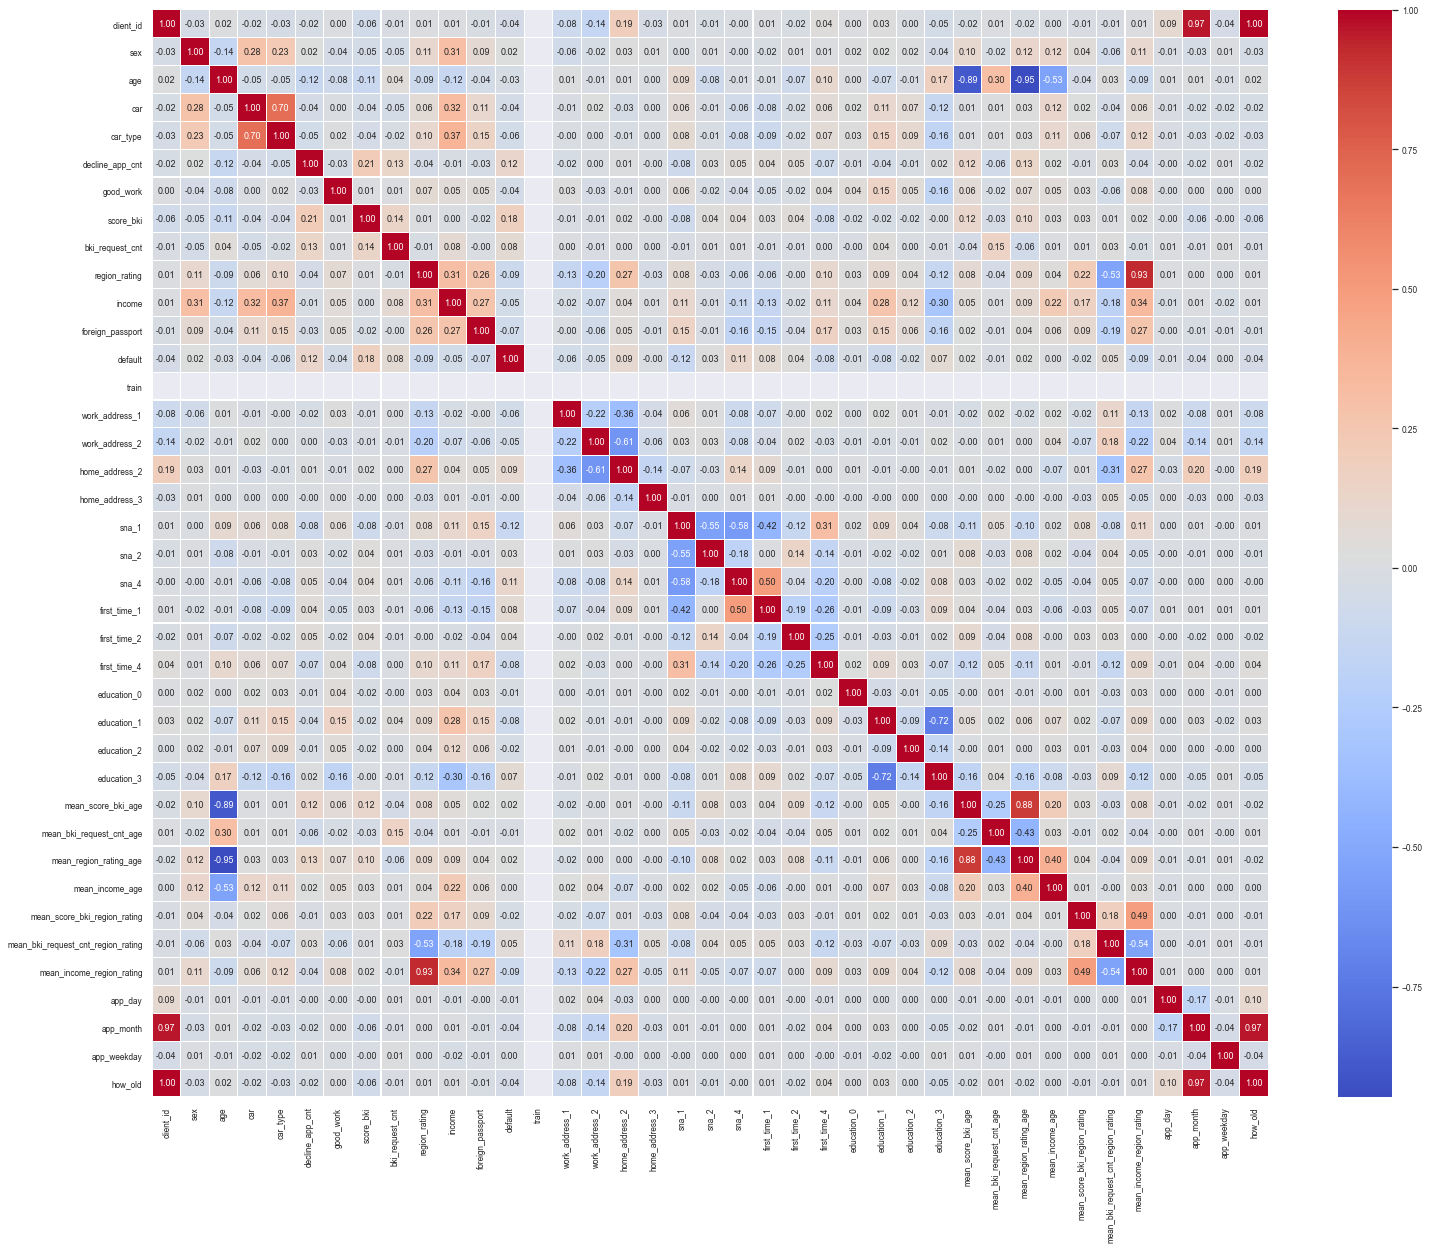

In [261]:
# Посмотрим на матрицу корреляций, особенно на новые признаки
sns.set(font_scale=0.75)
plt.subplots(figsize=(25, 20))
sns.heatmap(data[data['train'] == 1].corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

In [262]:
# Удалим часть признаков, имеющих сильную корреляцию и уже не нужный app_date
data.drop(['client_id', 'app_month', 'app_date', 'mean_score_bki_age', 
           'mean_region_rating_age', 'mean_income_region_rating'], axis=1, inplace=True)

In [263]:
# Добавим два новых признака в списко числовых признаков, а один - в категориальный
num_col.extend(['how_old', 'app_day'])
cat_col.append('app_weekday')

# Добавим все новые признаки в список числовых признаков
num_col.extend(['mean_bki_request_cnt_age', 'mean_income_age', 
                'mean_score_bki_region_rating', 'mean_bki_request_cnt_region_rating'])

## Полиномиальные признаки

In [264]:
# Cделаем новые полиномиальные признаки на основе всех числовых признаков (на основе одиннадцати)
# Сделаем это отдельным датафреймом и присоединим
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(data[num_col])[:, len(num_col):]
poly_cols = pf.get_feature_names()[len(num_col):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data_poly = data.join(poly_df,  how='left')

<AxesSubplot:>

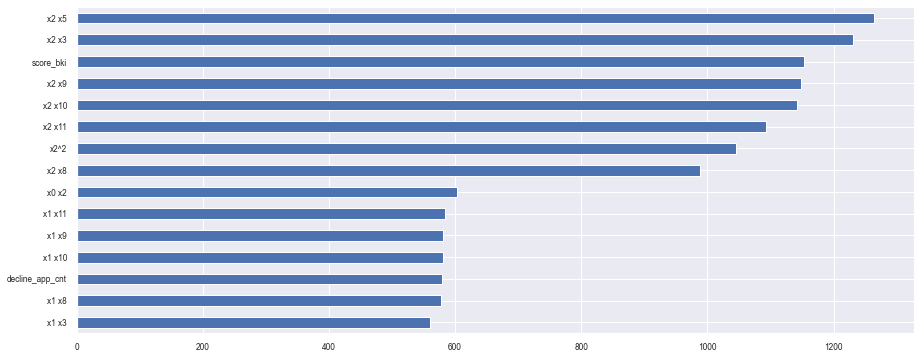

In [265]:
# Добавим все эти новые полиномиальные колонки с список числовых признаков
num_col.extend(poly_df.columns.to_list())

# Оценим значимость числовых признаков
imp_num = pd.Series(f_classif(data_poly[num_col], data_poly['default'])[0], index = num_col)
imp_num.sort_values(inplace = True)
imp_num[-15:].plot(kind = 'barh', figsize=(15,6))

In [266]:
# Из новых полиномиальных признаков оставим наиболее значимые и добавим их в рабочей датафрейм
data = data.join(poly_df[['x2 x5', 'x2 x3', 'x2 x9', 'x2 x10']],  how='left')

In [267]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,default,train,work_address_1,work_address_2,home_address_2,home_address_3,sna_1,sna_2,sna_4,first_time_1,first_time_2,first_time_4,education_0,education_1,education_2,education_3,mean_bki_request_cnt_age,mean_income_age,mean_score_bki_region_rating,mean_bki_request_cnt_region_rating,app_day,app_weekday,how_old,x2 x5,x2 x3,x2 x9,x2 x10
0,1,62,1,1,0.000000,0,-2.008753,0.693147,5.0,9.798183,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0.901260,9.917638,-1.914400,0.878846,1,5,31,-10.043765,-19.682128,-19.922084,3.845557
1,0,59,0,0,0.000000,0,-1.532276,1.386294,5.0,9.852247,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0.914524,9.997499,-1.914400,0.878846,12,2,70,-7.661381,-15.096364,-15.318931,2.933390
2,1,25,1,0,1.098612,0,-1.408142,0.693147,8.0,10.308986,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0.828157,10.305359,-1.900764,0.836388,1,5,31,-11.265138,-14.516519,-14.511411,2.676547
3,0,53,0,0,0.000000,0,-2.057471,1.098612,5.0,9.210440,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0.939274,10.299262,-1.914400,0.878846,23,3,22,-10.287357,-18.950217,-21.190437,3.938823
4,1,48,0,0,0.000000,1,-1.244723,0.693147,6.0,10.308986,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0.947087,10.414138,-1.916914,0.891563,18,4,107,-7.468336,-12.831829,-12.962714,2.386026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,37,0,0,0.693147,0,-1.744976,1.386294,5.0,9.615872,0,-1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0.916491,10.448692,-1.914400,0.878846,31,0,89,-8.724879,-16.779464,-18.232713,3.340582
110144,0,64,1,1,0.000000,0,-2.293781,1.386294,6.0,12.206078,0,-1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0.912570,9.818519,-1.916914,0.891563,25,4,114,-13.762689,-27.998075,-22.521538,4.396981
110145,1,31,0,0,1.098612,0,-0.940752,0.693147,5.0,11.002117,0,-1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0.894346,10.444038,-1.914400,0.878846,30,6,88,-4.703760,-10.350262,-9.825249,1.800975
110146,0,27,0,0,0.693147,0,-1.242392,1.098612,8.0,10.308986,0,-1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0.856904,10.380372,-1.900764,0.836388,7,1,6,-9.939134,-12.807799,-12.896488,2.361494


# Модель с новыми признаками

In [268]:
# Сделаем копию датафрейма
df = data.copy()

In [269]:
df_train = df.query('train == 1').drop(['train'], axis=1)
df_test = df.query('train == 0').drop(['train'], axis=1)

# Делим тренировочные данные на обучающуюся и проверочную
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values

rus = RandomUnderSampler(random_state=42)
X_us, Y_us = rus.fit_resample(X, Y)

# Стандартизируем значения признаков
X_us = StandardScaler().fit_transform(X_us)

x_train, x_test, y_train, y_test = train_test_split(X_us, Y_us, test_size=0.20, random_state=42)

In [270]:
"""# Разбиваем выборку на трейн и тест
df_train = df.query('train == 1').drop(['train'], axis=1)
df_test = df.query('train == 0').drop(['train'], axis=1)

# Вспоминаем, что целевая переменная распределена неравномерно. Сделаем oversampling, т.е. сделаем копии объектов, где default=1
default_0 = df_train[df_train['default'] == 0]
default_1 = df_train[df_train['default'] == 1]
default_new = int(len(default_0)/len(default_1))
for i in range(default_new):
    df_train = df_train.append(default_1).reset_index(drop=True) 

# Делим тренировочные данные на обучающуюся и проверочную
X = df_train.drop(['default'], axis=1).values
Y = df_train['default'].values

# Стандартизируем значения признаков
X = StandardScaler().fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)"""

"# Разбиваем выборку на трейн и тест\ndf_train = df.query('train == 1').drop(['train'], axis=1)\ndf_test = df.query('train == 0').drop(['train'], axis=1)\n\n# Вспоминаем, что целевая переменная распределена неравномерно. Сделаем oversampling, т.е. сделаем копии объектов, где default=1\ndefault_0 = df_train[df_train['default'] == 0]\ndefault_1 = df_train[df_train['default'] == 1]\ndefault_new = int(len(default_0)/len(default_1))\nfor i in range(default_new):\n    df_train = df_train.append(default_1).reset_index(drop=True) \n\n# Делим тренировочные данные на обучающуюся и проверочную\nX = df_train.drop(['default'], axis=1).values\nY = df_train['default'].values\n\n# Стандартизируем значения признаков\nX = StandardScaler().fit_transform(X)\n\nx_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)"

In [271]:
# Делаем обычную логистическую регрессию
model_3 = LogisticRegression(max_iter=2000)
model_3.fit(x_train, y_train)
y_pred_3 = model_3.predict(x_test)
y_proba_3 = model_3.predict_proba(x_test)[:,1]

Верность - accuracy_score: 0.6671
Точность - precision_score: 0.674
Полнота - recall_score: 0.6619
f1_score: 0.6679


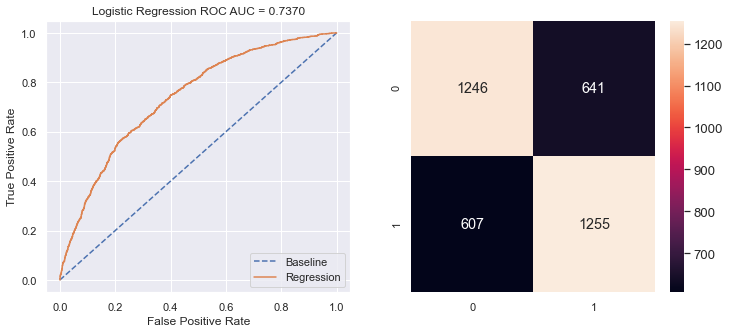

In [272]:
pain_roc_curve(y_test, y_proba_3, y_pred_3)
show_metrics(y_pred_3, y_test)

Модель очень незначительно улучшилась

# Экспериментируем с гиперпараметрами

In [ ]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=2000)
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

При выполнении кода, представленного в модуле (выше он закомментирован), выскакивает повторение одной ошибки. В итоге лучшие гиперпараметры С=2.7825594022071245 и l2. Модель при таких параметрах почти не меняет свои результаты. 

In [ ]:
# Делаем логистическую регрессию с вычисленными параметрами
model_4 = LogisticRegression(max_iter=2000, C=2.7825594022071245, penalty='l2' )
model_4.fit(x_train, y_train)
y_pred_4 = model_4.predict(x_test)
y_proba_4 = model_4.predict_proba(x_test)[:,1]

In [ ]:
pain_roc_curve(y_test, y_proba_4, y_pred_4)
show_metrics(y_pred_4, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=2000, solver='liblinear')
model.fit(x_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(x_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

При изменении кода для поиска гиперпараметров происходит долгий подсчёт (в районе 20-ти минут).Такие параметры очень слабо повлияли на результат моделирования.

In [ ]:
# Делаем логистическую регрессию с вычисленными параметрами
model_5 = LogisticRegression(max_iter=2000, C=1291.5496650148827, penalty='l1', solver='liblinear')
model_5.fit(x_train, y_train)
y_pred_5 = model_5.predict(x_test)
y_proba_5 = model_5.predict_proba(x_test)[:,1]

In [ ]:
pain_roc_curve(y_test, y_proba_5, y_pred_5)
show_metrics(y_pred_5, y_test)

# submission

In [ ]:
df_test.drop('default', axis=1, inplace=True)

Методом проб было выяснено, что submission показывает лучше результат на 5 модели (после второго подбора гиперпараметров), поэтому использую эту модель

In [ ]:
X_sub = df_test.values
X_sub = StandardScaler().fit_transform(X_sub)
y_pred_5 = model_5.predict(X_sub)
y_pred_5

In [ ]:
y_pred_prob_test = model_5.predict_proba(X_sub)[:,1]
y_pred_prob_test

In [ ]:
new_sample_submission = pd.DataFrame({'client_id': test.client_id, 'default': y_pred_prob_test})
new_sample_submission.to_csv('submission.csv', index=False)
new_sample_submission.head(10)